<a href="https://colab.research.google.com/github/Ramesh-Arvind/Time_Series_Analysis/blob/master/Energy_consumption_multi_seasonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install NeuralProphet
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 781.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.2/185.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.statespace.structural import UnobservedComponents
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

plt.style.use('fivethirtyeight')
from pathlib import Path
from statsmodels.tools.eval_measures import rmse, rmspe

plt.rcParams["figure.figsize"] = [14, 10]

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
energy_path = Path(
    "/content/AEP_hourly.csv")

df = pd.read_csv(energy_path, index_col='Datetime', parse_dates=True)
df.sort_index(inplace=True)
df = df.resample('H').max()
df.columns = ['y']
df.ffill(inplace=True)

In [4]:

# EDA
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]

    if label:
        y = df[label]
        return X, y
    return X


X, y = create_features(df, label='y')

features = pd.concat([X, y], axis=1)

print(features.head())

WARNING - (py.warnings._showwarnmsg) - <ipython-input-4-dbccbf207829>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear

  df['weekofyear'] = df['date'].dt.weekofyear



                     hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2004-10-01 01:00:00     1          4        4     10  2004        275   
2004-10-01 02:00:00     2          4        4     10  2004        275   
2004-10-01 03:00:00     3          4        4     10  2004        275   
2004-10-01 04:00:00     4          4        4     10  2004        275   
2004-10-01 05:00:00     5          4        4     10  2004        275   

                     dayofmonth  weekofyear        y  
Datetime                                              
2004-10-01 01:00:00           1          40  12379.0  
2004-10-01 02:00:00           1          40  11935.0  
2004-10-01 03:00:00           1          40  11692.0  
2004-10-01 04:00:00           1          40  11597.0  
2004-10-01 05:00:00           1          40  11681.0  


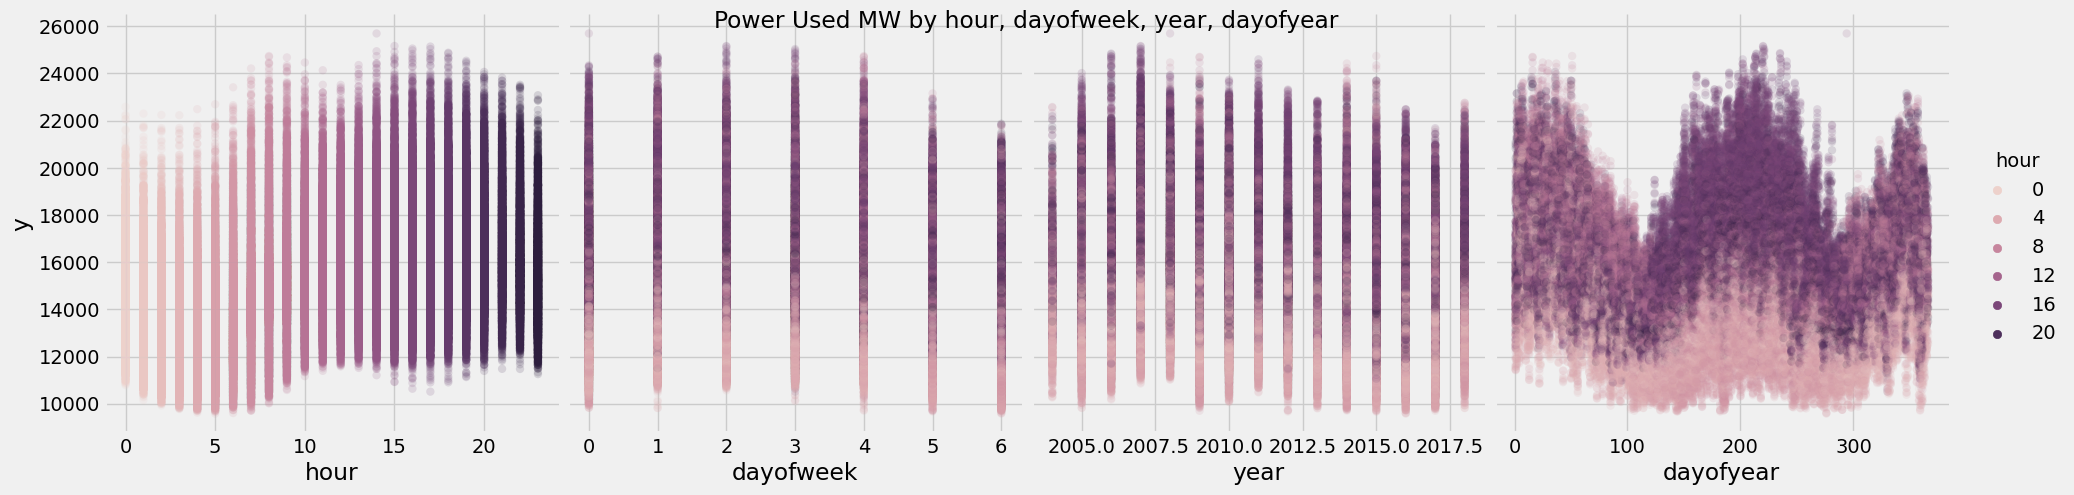

In [5]:

# Seaborn plot
sns = sns.pairplot(features.dropna(),
                   hue='hour',
                   x_vars=['hour', 'dayofweek', 'year', 'dayofyear'],
                   y_vars='y',
                   height=5,
                   plot_kws={'alpha': 0.15, 'linewidth': 0})
plt.suptitle('Power Used MW by hour, dayofweek, year, dayofyear')
plt.show()


A new  approach for decomposing time series with multiple seasonality was introduced in a paper published by Bandara, Hyndman, and Bergmeir, titled MSTL: A SeasonalTrend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns. The
paper was published in July 2021, which you can read here: http://arxiv.org/abs/2107.13462.


day = 24 hours
week = 168 hours
month = 731 hours
year = 8772 hours



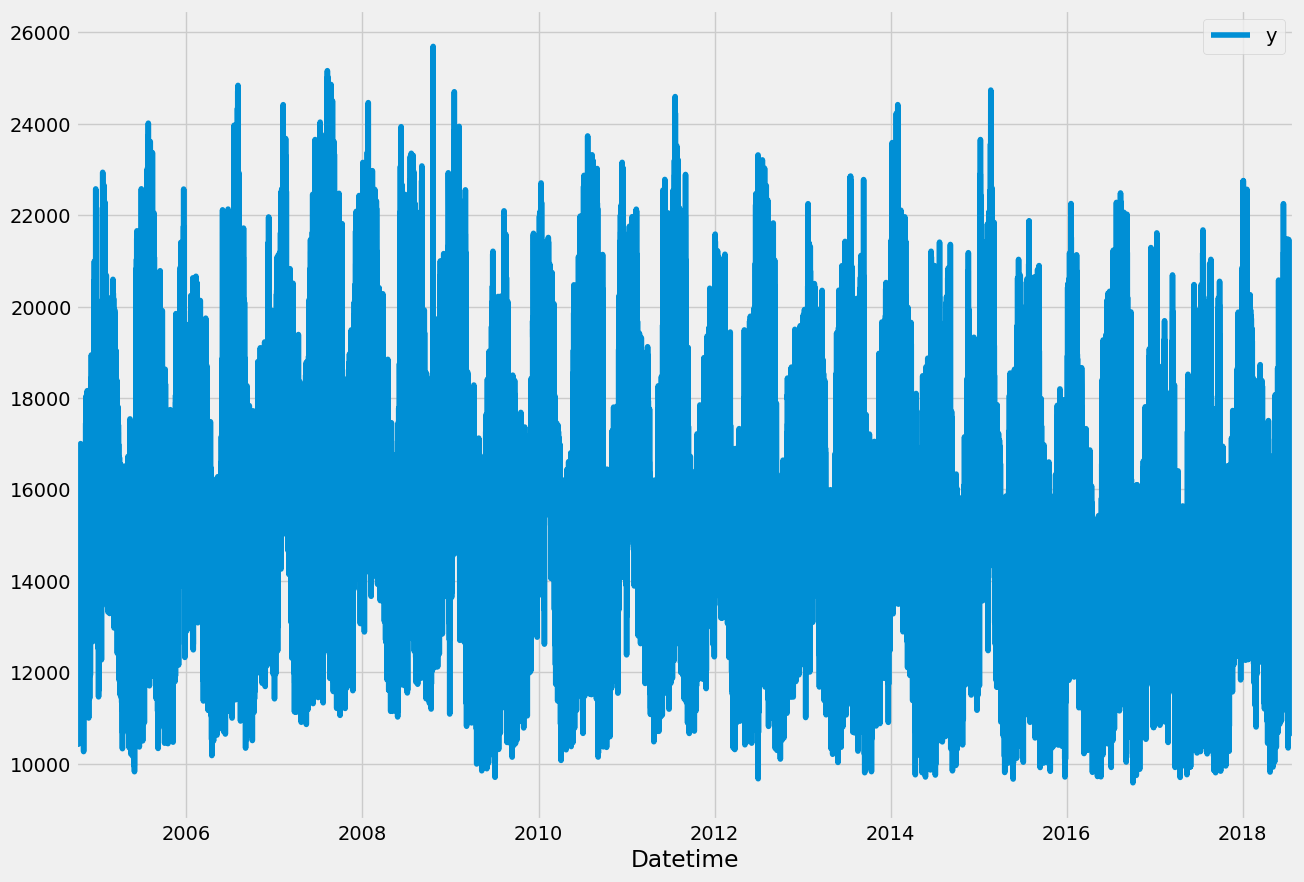

<Figure size 1400x800 with 0 Axes>

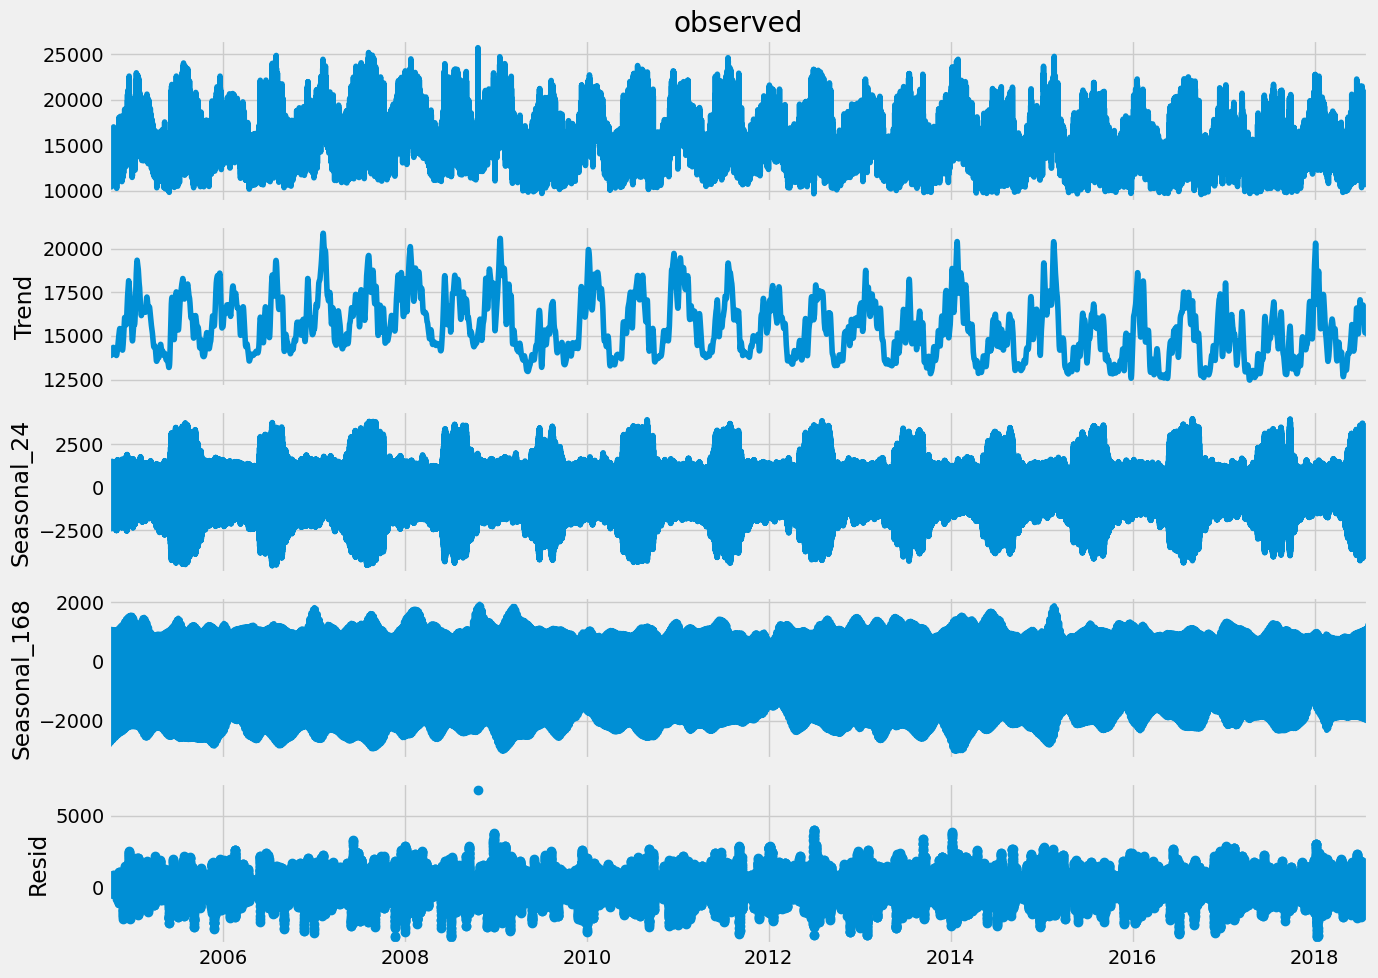

In [6]:

day = 24
week = day * 7
month = round(week * 4.35)
year = round(month * 12)
print(f'''
day = {day} hours
week = {week} hours
month = {month} hours
year = {year} hours
''')

df.plot()
plt.show()

df.index.freq
mstl = MSTL(df, periods=(24, 24 * 7))
results = mstl.fit()
plt.figure(figsize=(14, 8))
ax = results.plot()
ax.tight_layout
plt.show()


1. Generally in day time the electicity peaks over the night time
2. Consumption of electricity is higher on weekdays compared to weekends when people go out
3. Annual pattern shows higher energy consumption in summer than winter
Will plot and see how it is in graph

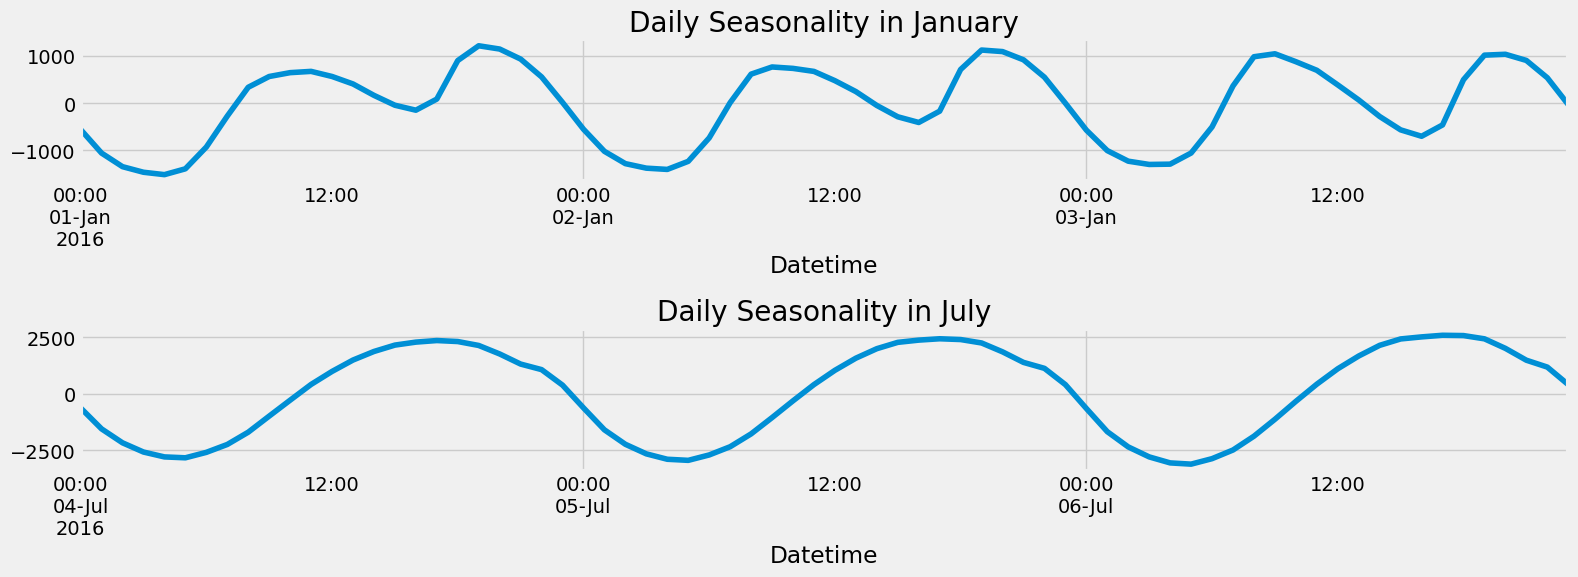

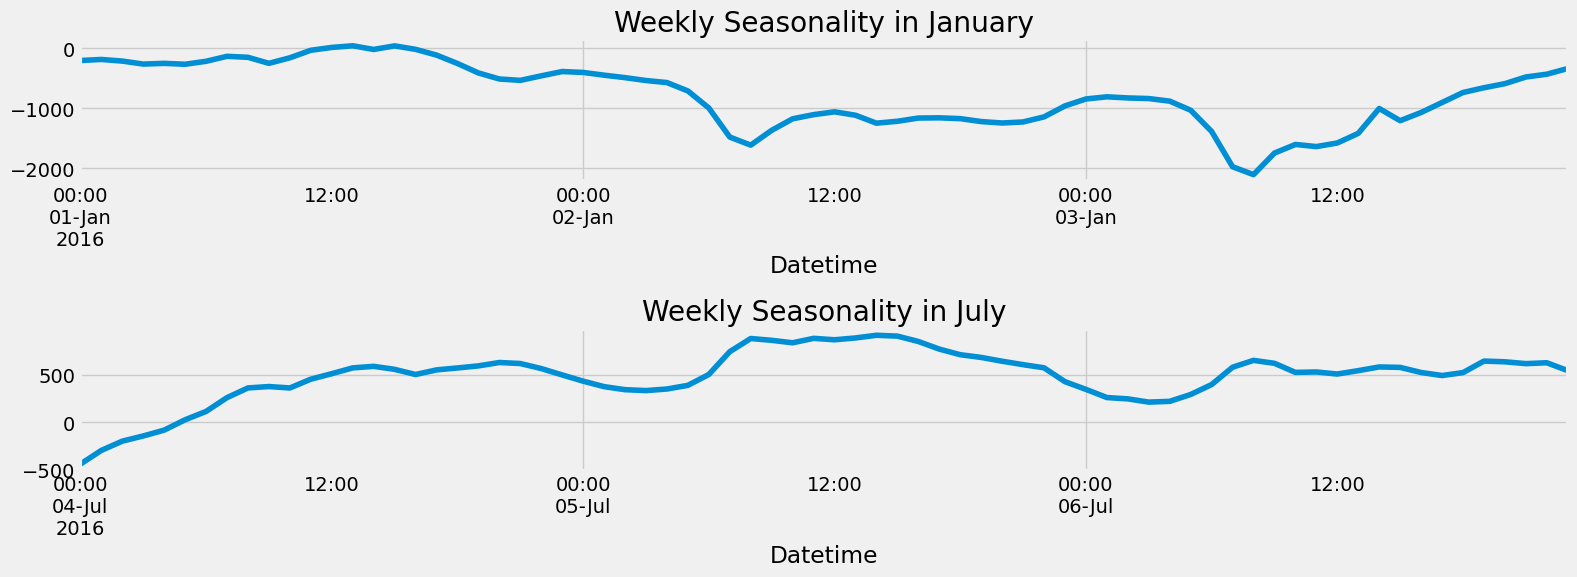

                     seasonal_24  seasonal_168
Datetime                                      
2004-10-01 01:00:00 -1679.480941    310.793623
2004-10-01 02:00:00 -2118.502842    305.601582
2004-10-01 03:00:00 -2366.747343    300.390028
2004-10-01 04:00:00 -2436.134303    315.263059
2004-10-01 05:00:00 -2328.267260    356.349291
...                          ...           ...
2018-08-02 20:00:00  2474.844589    387.676073
2018-08-02 21:00:00  1734.443244    389.830116
2018-08-02 22:00:00  1239.335395    406.616123
2018-08-02 23:00:00   244.281157    302.300445
2018-08-03 00:00:00 -1007.984824    221.104497

[121296 rows x 2 columns]


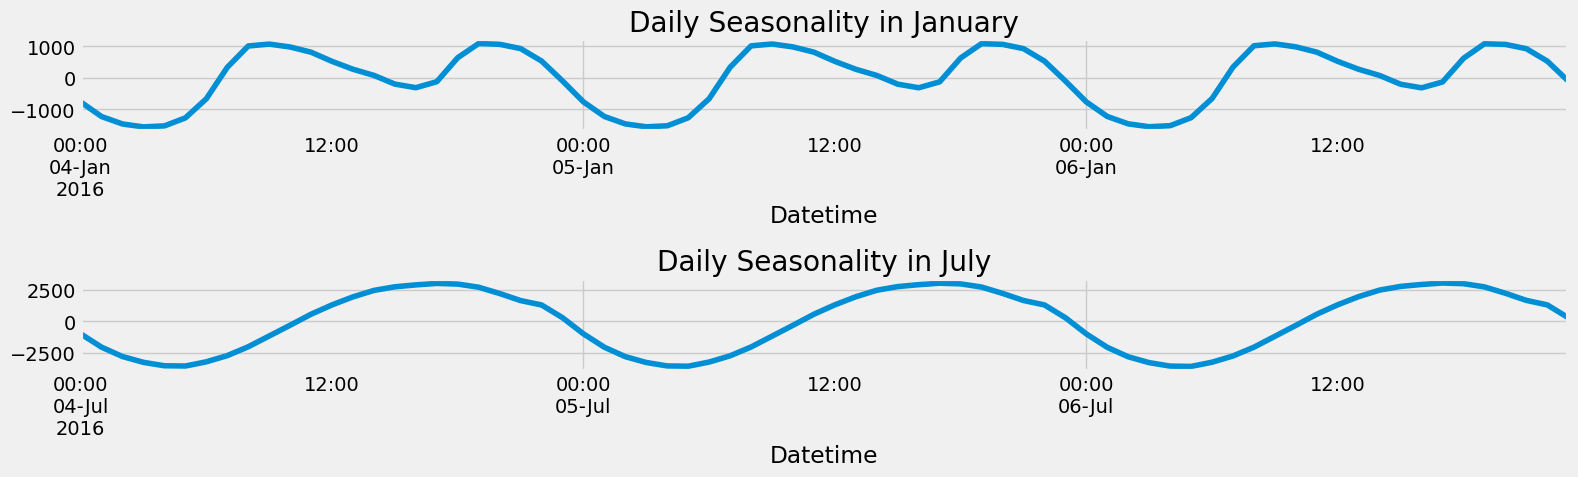

In [7]:
# Daily Seasonal Pattern comparing with winter and summer
fig, ax1 = plt.subplots(2, 1, figsize=(16, 6))
results.seasonal['seasonal_24'].loc['2016-01-01': '2016-01-03'].plot(ax=ax1[0],
                                                                     title='Daily Seasonality in January')
results.seasonal['seasonal_24'].loc['2016-07-04':'2016-07-06'].plot(ax=ax1[1],
                                                                    title='Daily Seasonality in July')
fig.tight_layout()
plt.show()

# Weekly Seasonal Pattern comparing with winter and summer
fig1, ax2 = plt.subplots(2, 1, figsize=(16, 6))
results.seasonal['seasonal_168'].loc['2016-01-01': '2016-01-03'].plot(ax=ax2[0],
                                                                      title='Weekly Seasonality in January')
results.seasonal['seasonal_168'].loc['2016-07-04':'2016-07-06'].plot(ax=ax2[1],
                                                                     title='Weekly Seasonality in July')
fig1.tight_layout()
plt.show()

mstl = MSTL(df, periods=(24, 24 * 7), iterate=4, windows=[121, 121])
results = mstl.fit()

print(results.seasonal)

fig3, ax3 = plt.subplots(2, 1, figsize=(16, 5))
(results.seasonal['seasonal_24']
 .loc['2016-01-04':'2016-01-06']
 .plot(ax=ax3[0],
       title='Daily Seasonality in January'))
(results.seasonal['seasonal_24']
 .loc['2016-07-04':'2016-07-06']
 .plot(ax=ax3[1],
       title='Daily Seasonality in July'))
fig3.tight_layout()
plt.show()



Unobserved Common Model

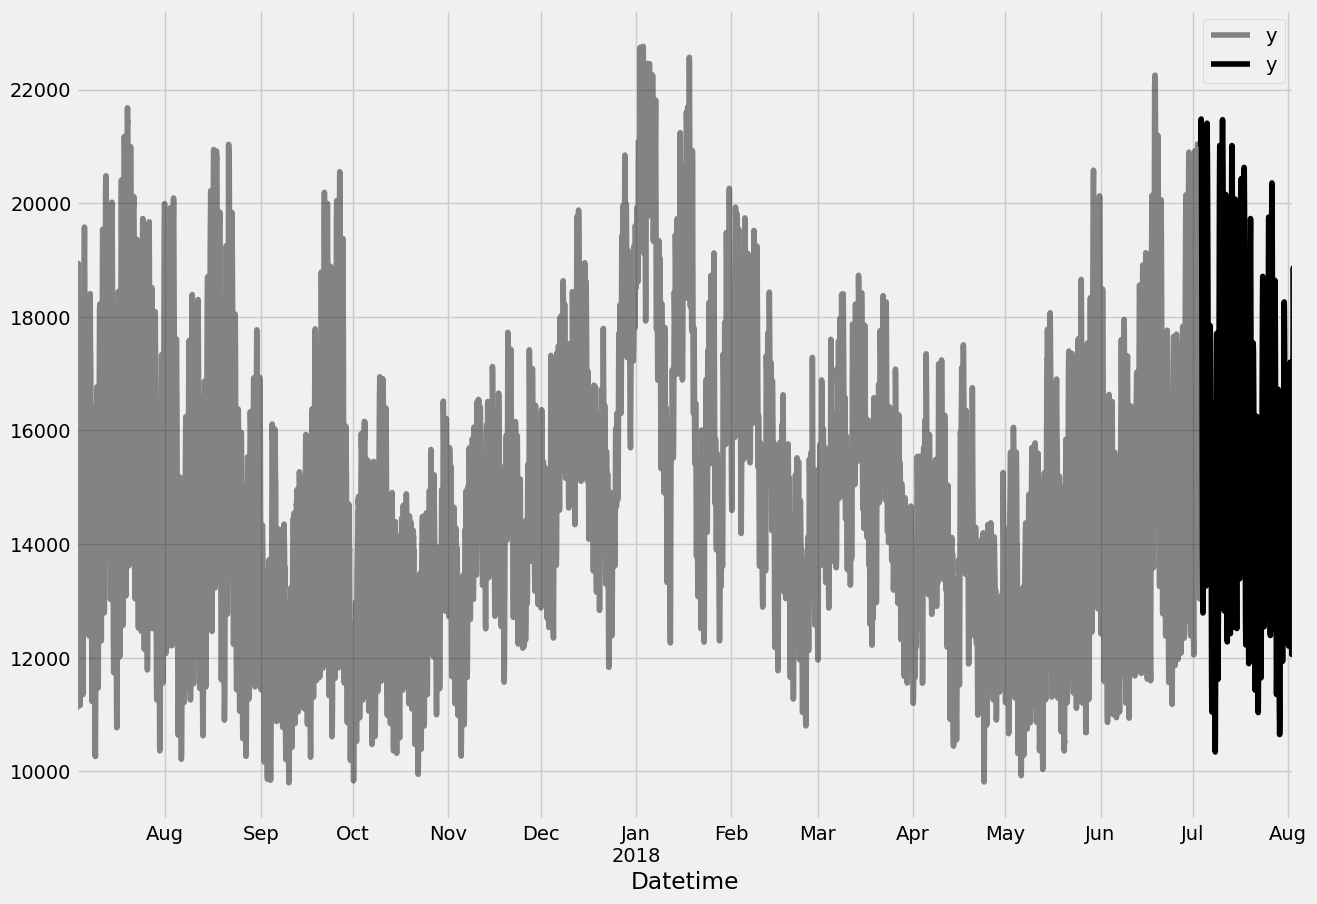

121296
120565
731
1.4930250607626478


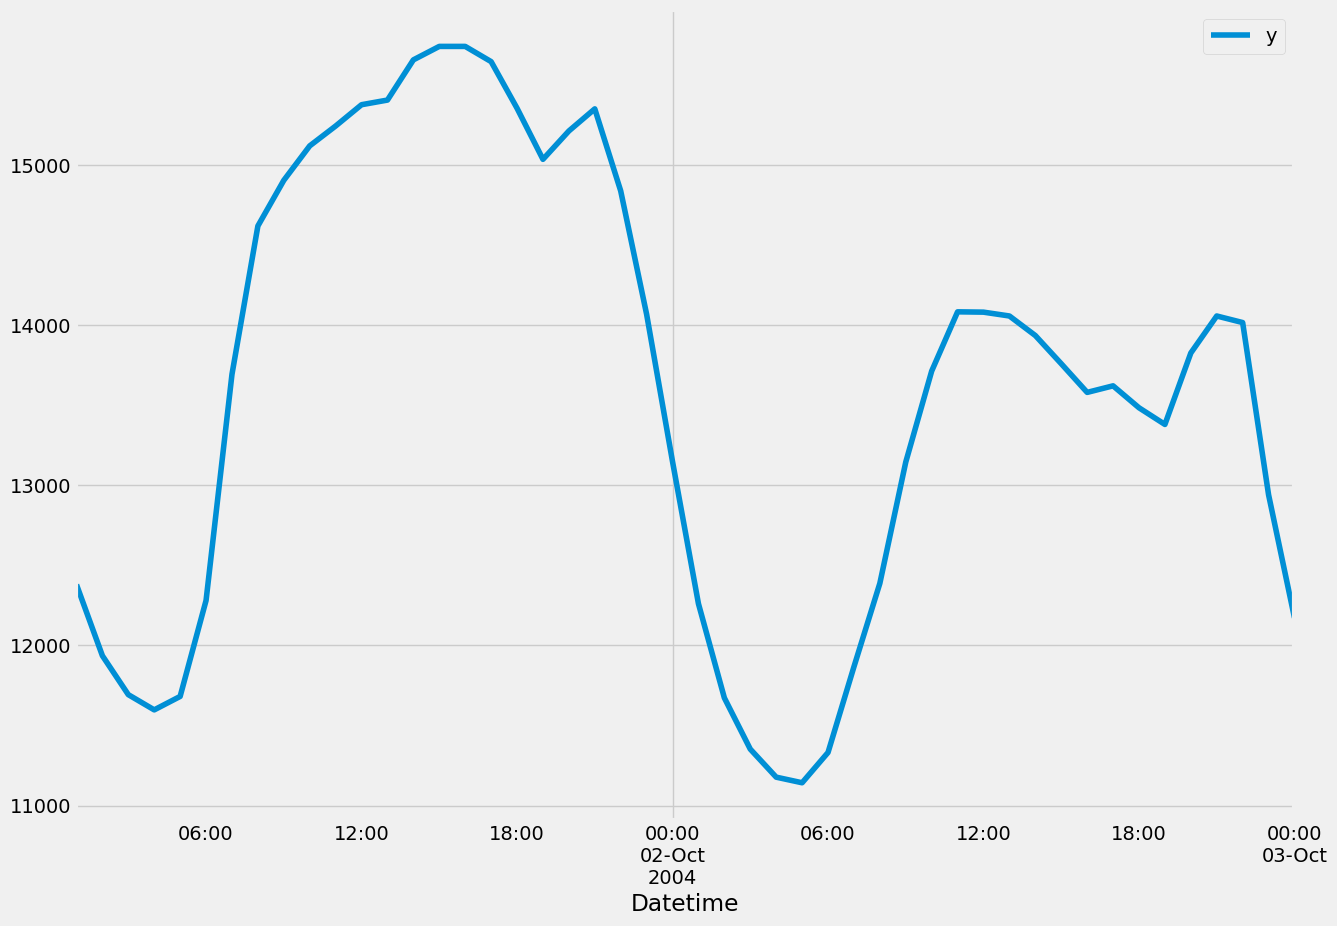

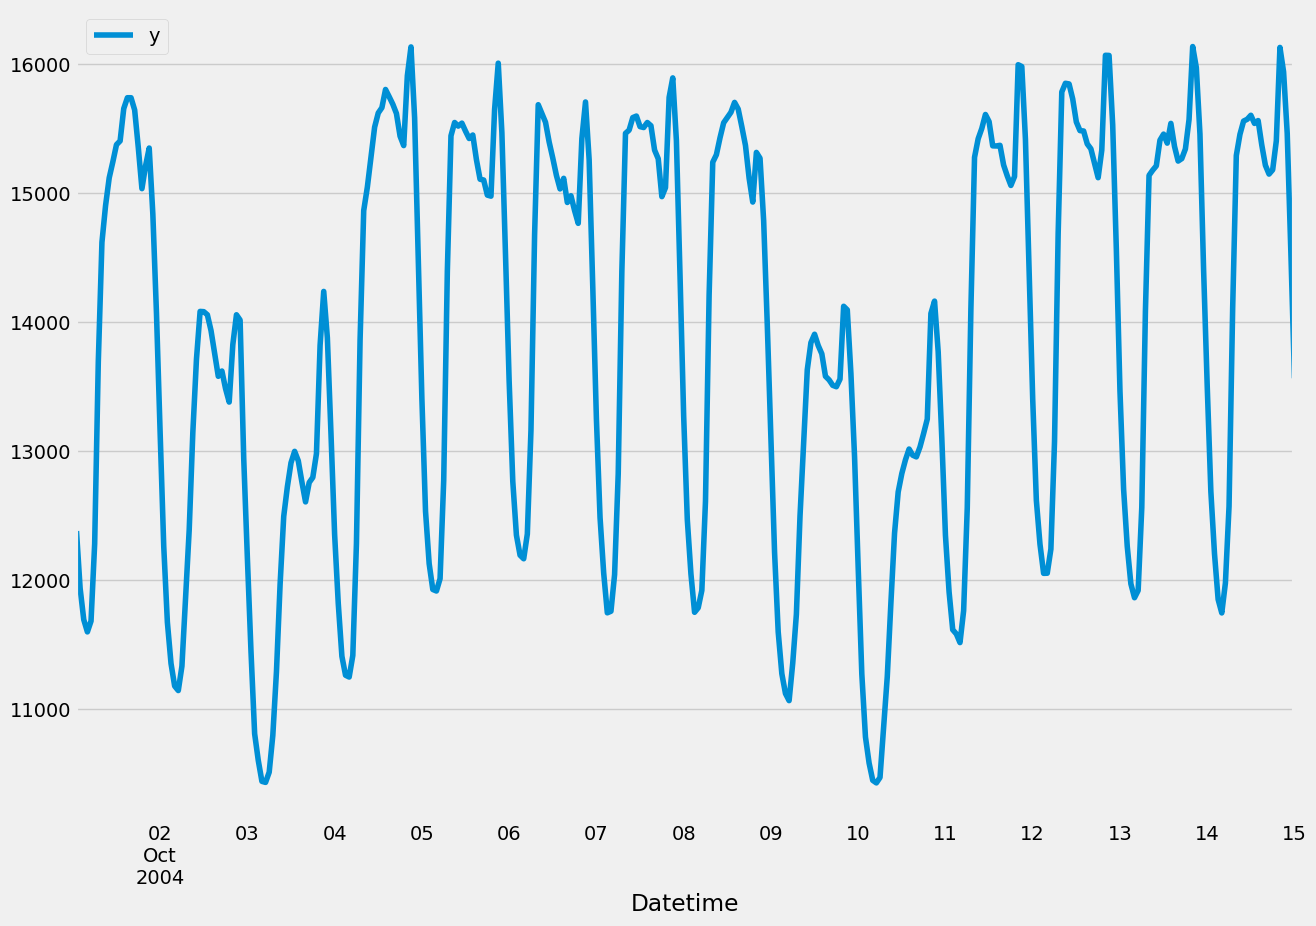

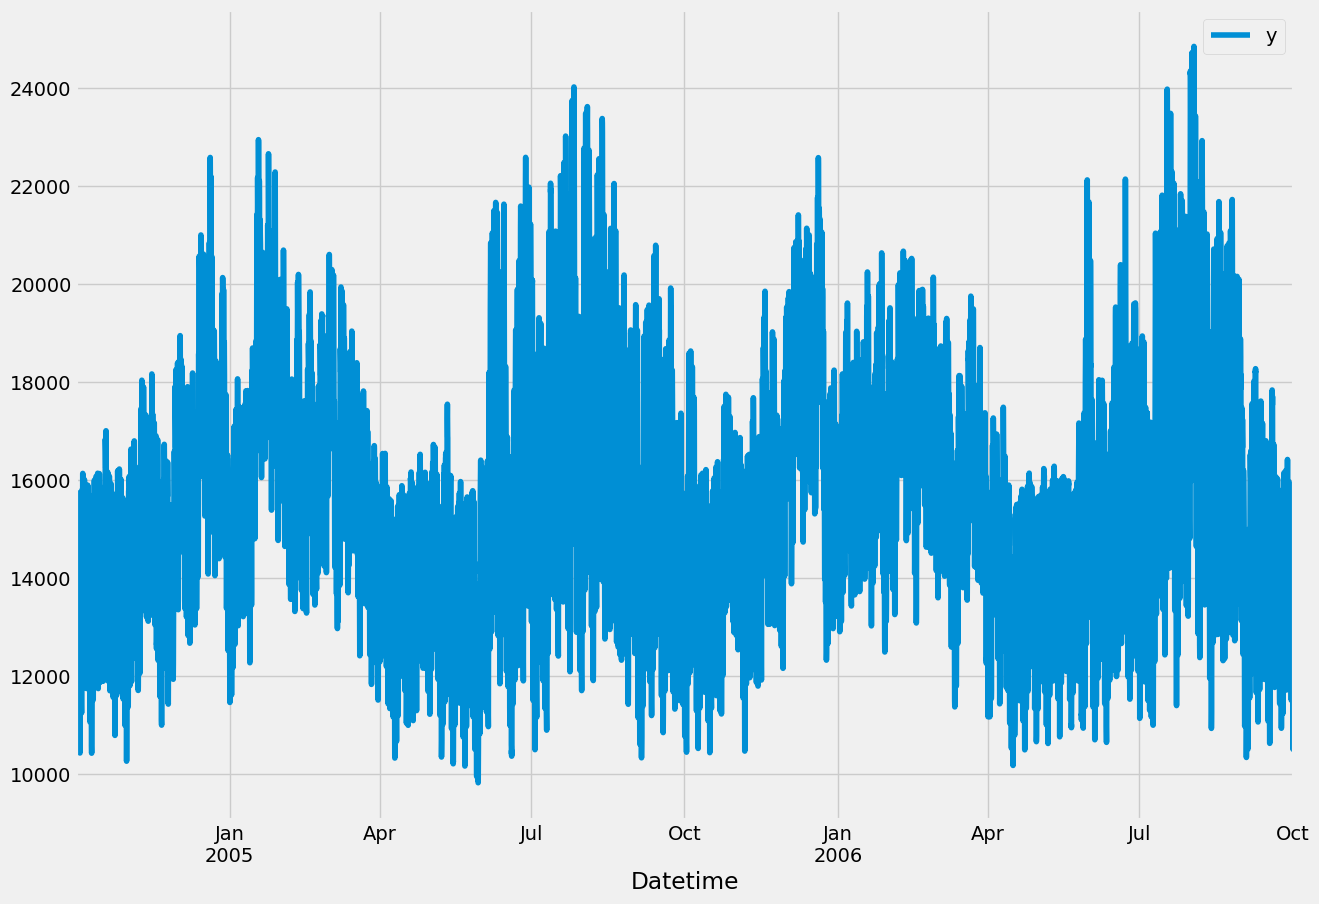

In [8]:
train = df.iloc[:-month]
test = df.iloc[-month:]
ax = train.iloc[-year:].plot(style='k-', alpha=0.45)
test.plot(ax=ax, style='k')
plt.show()

print(len(df))
print(len(train))
print(len(test))
print(len(test) / len(df.loc['2013':]) * 100)

train.iloc[:day * 2].plot()
plt.show()

train.iloc[:week * 2].plot()
plt.show()

train.iloc[:year * 2].plot()
plt.show()


In general the fit method in ucm it used lbfgs
L-BFGS is a memory-efficient variant of the BFGS (Broyden-Fletcher-Goldfarb-Shanno) optimization algorithm.
The "limited-memory" aspect means that it approximates the Hessian matrix (a matrix of second derivatives) of the objective function without explicitly storing the entire matrix.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"

  warn("Value of `%s` may be overridden when the trend"



                           Unobserved Components Results                            
Dep. Variable:                            y   No. Observations:               120565
Model:                  deterministic trend   Log Likelihood            -1065389.355
                     + freq_seasonal(24(2))   AIC                        2130780.710
                    + freq_seasonal(168(2))   BIC                        2130790.410
                   + freq_seasonal(8772(2))   HQIC                       2130783.629
Date:                      Sat, 23 Sep 2023                                         
Time:                              16:45:24                                         
Sample:                          10-01-2004                                         
                               - 07-03-2018                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|     

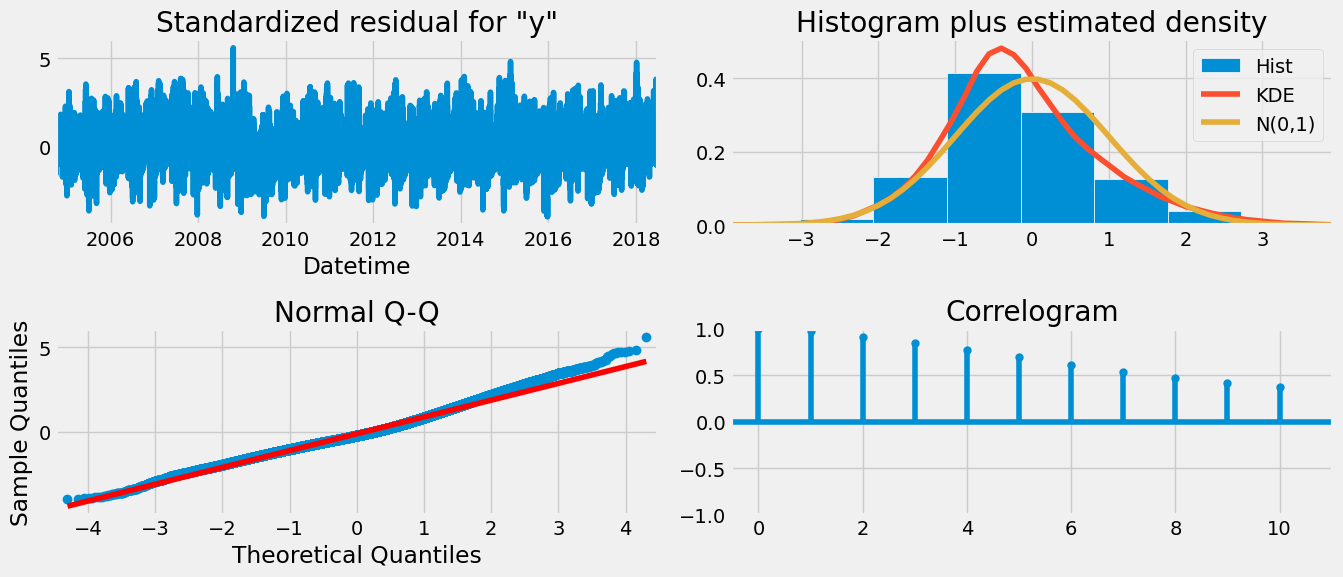

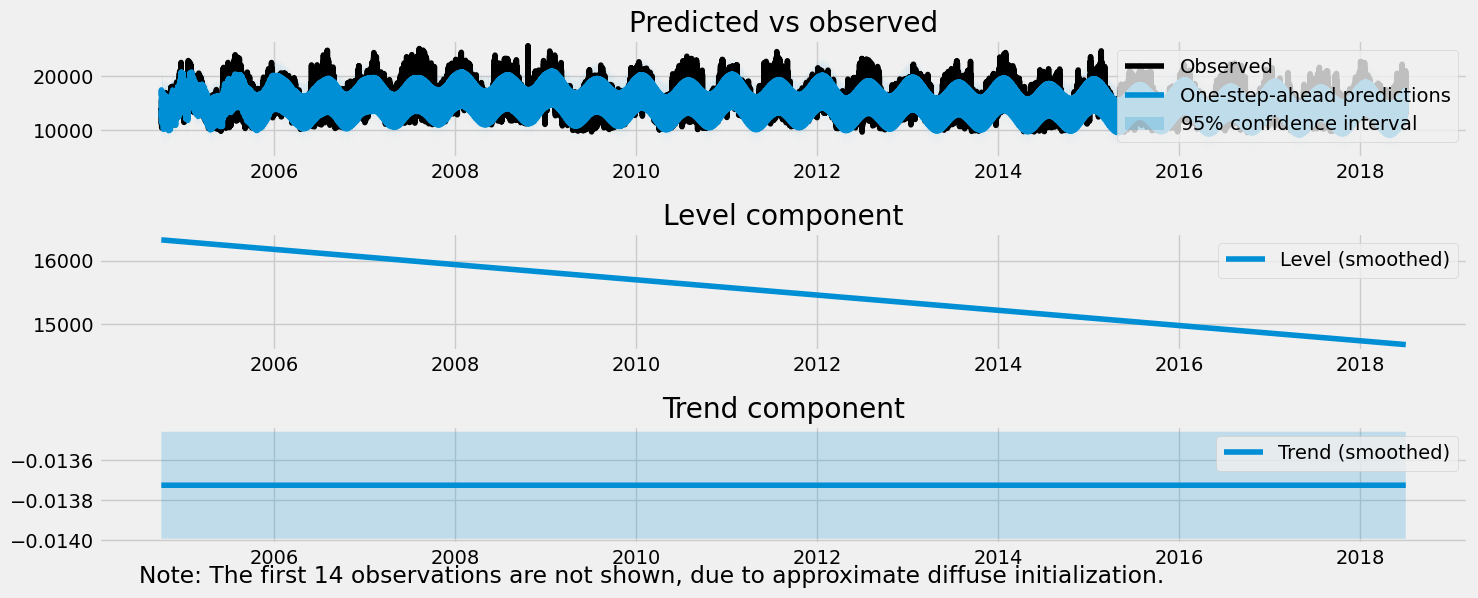

{'filtered': array([2543.19744595, 2720.60099486, 2304.37359427, ...,  950.55931397,
        984.09816928,  924.22922749]), 'filtered_cov': array([1.79455550e+06, 1.78370917e+06, 1.81277007e+06, ...,
       9.07369845e+01, 9.07357176e+01, 9.07342125e+01]), 'smoothed': array([-1470.14418931, -2065.58328889, -2399.39969629, ...,
         950.70039304,   984.19831216,   924.22922749]), 'smoothed_cov': array([90.73421251, 90.73445136, 90.734966  , ..., 90.73496603,
       90.73445138, 90.73421253]), 'offset': 2, 'pretty_name': 'seasonal 24(2)'}


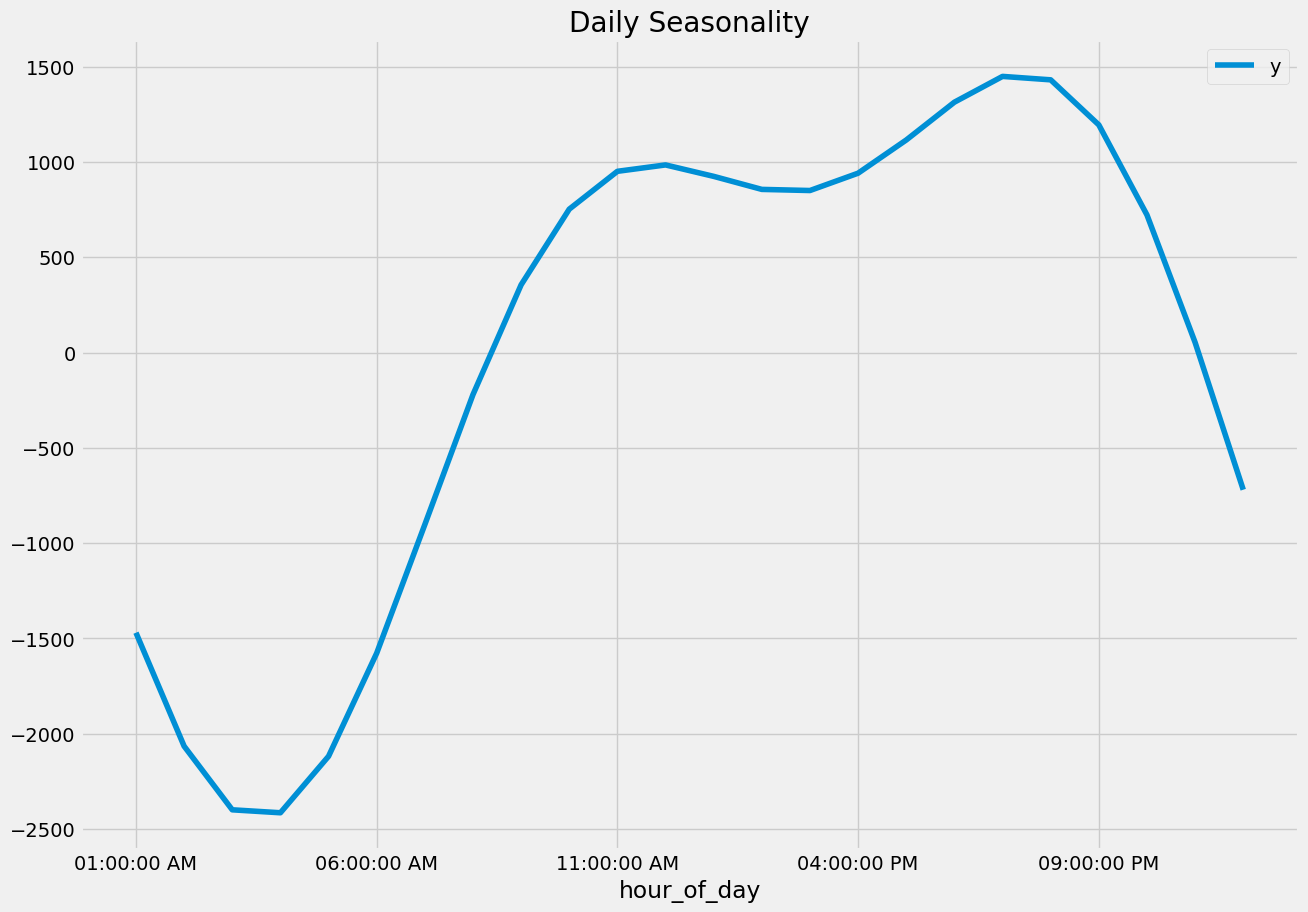

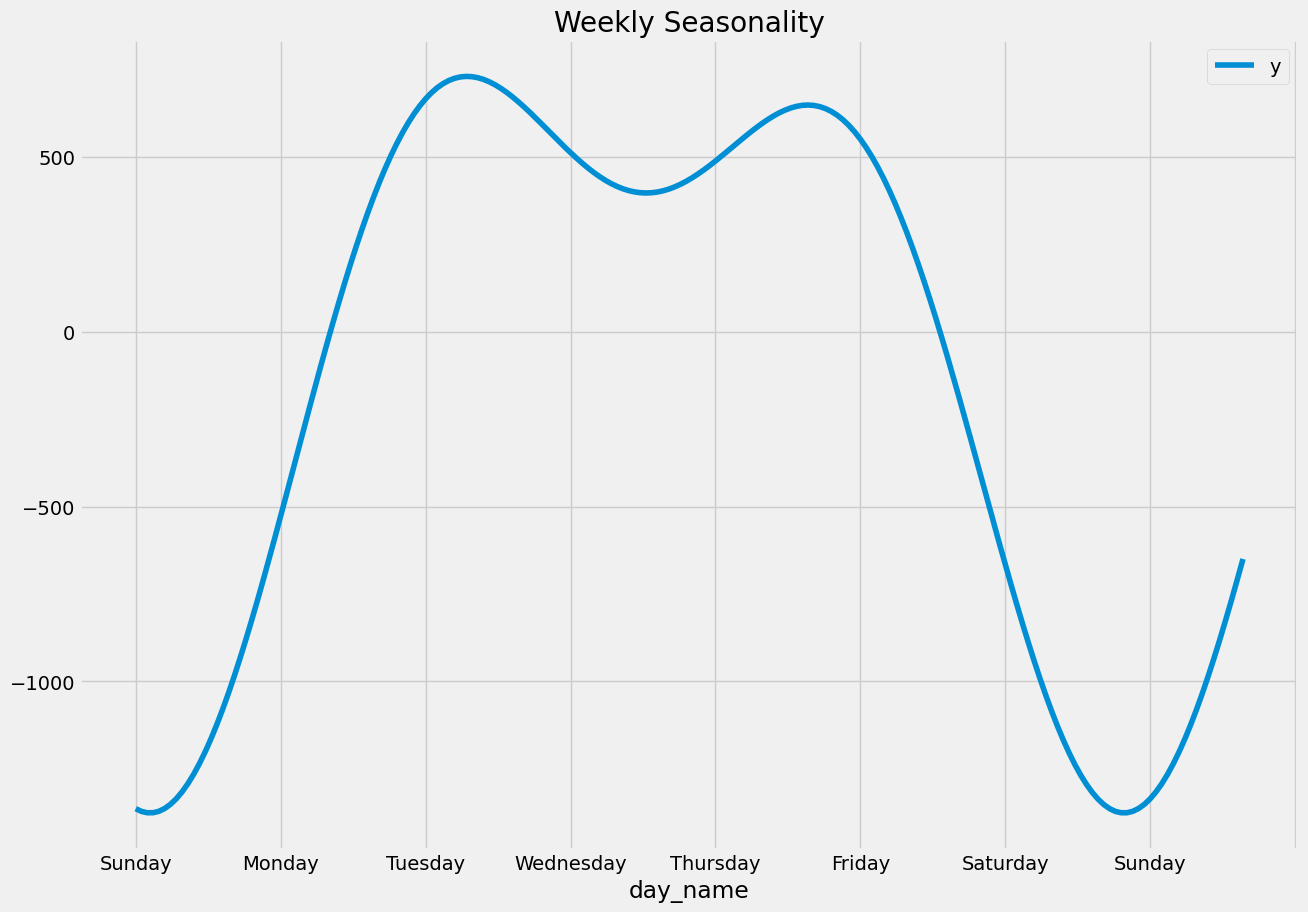

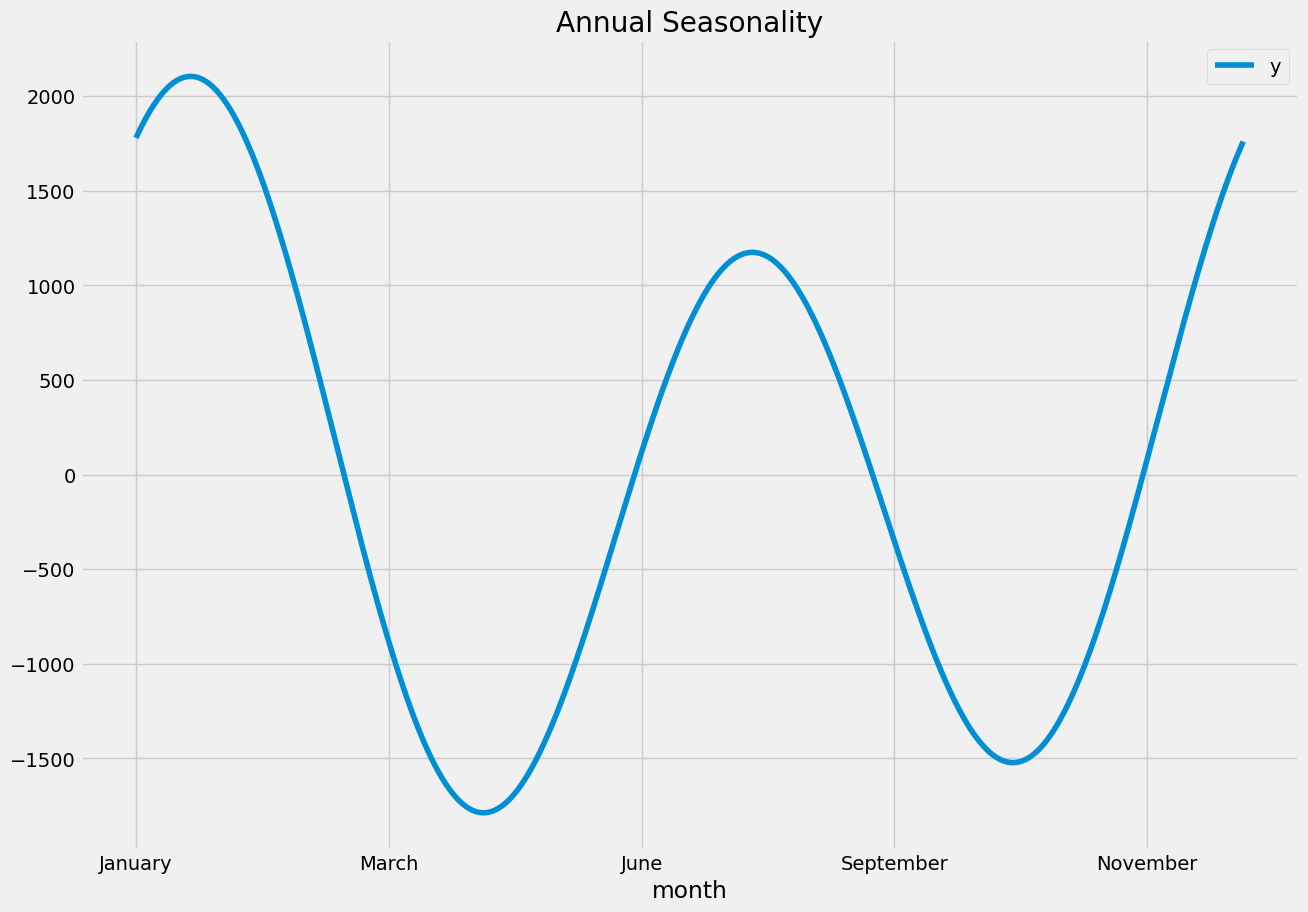

1.0676342739055271
1716.1196104178475


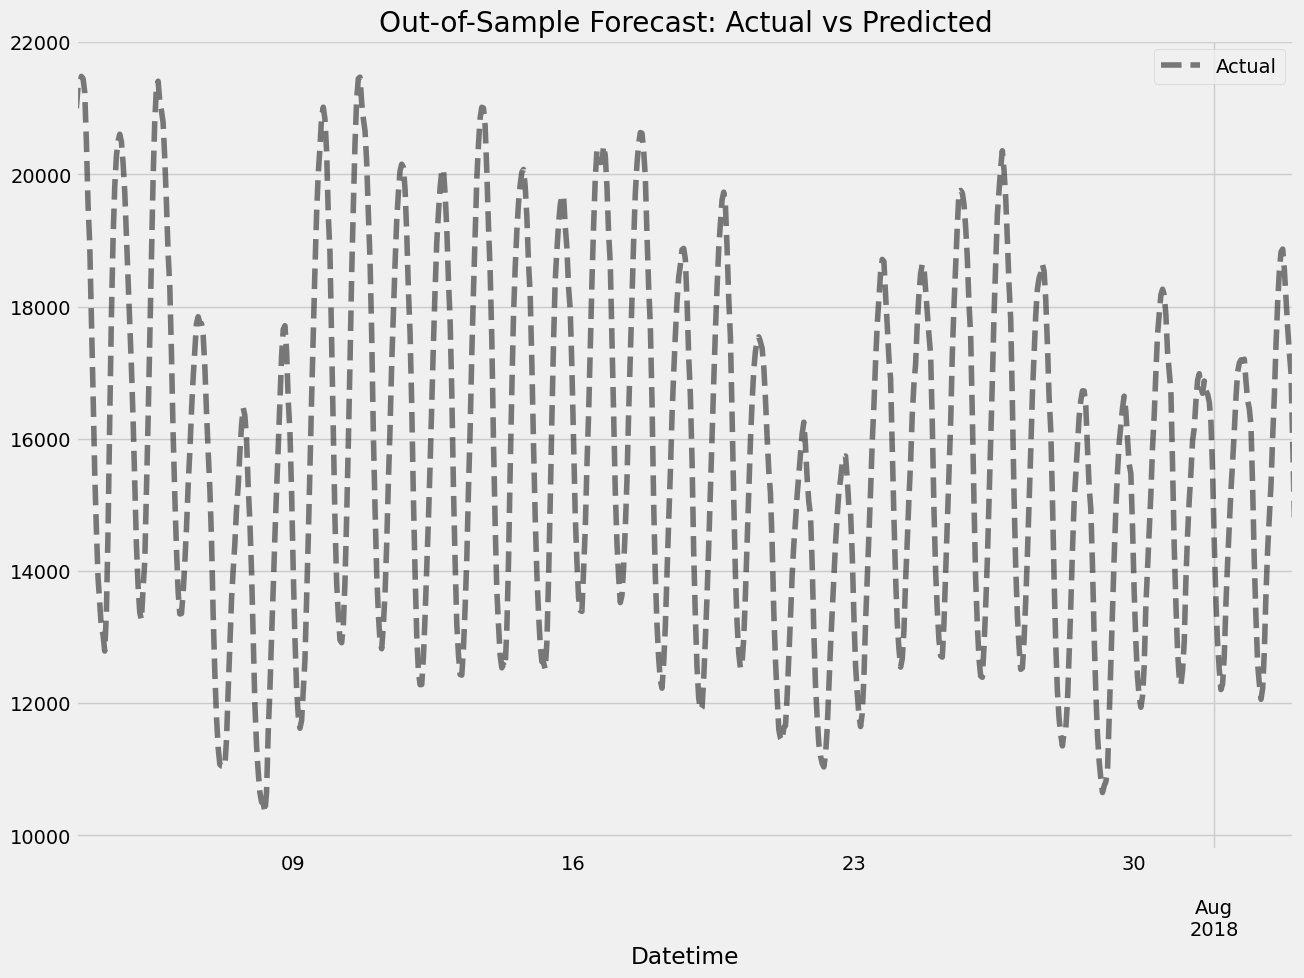

In [9]:
params = {'level': 'dtrend',
          'irregular': True,
          'freq_seasonal': [{'period': day, 'harmonics': 2},
                            {'period': week, 'harmonics': 2},
                            {'period': year, 'harmonics': 2}],
          'stochastic_freq_seasonal': [False, False, False]}

model = UnobservedComponents(train, **params)

results = model.fit()
print(results)
print(results.summary())

fig = results.plot_diagnostics(figsize=(14, 6))
fig.tight_layout()
plt.show()

fig = results.plot_components(figsize=(15, 6),
                              freq_seasonal=False,
                              which='smoothed')
fig.tight_layout()
plt.show()
print(results.freq_seasonal[0])

daily = pd.DataFrame(results.freq_seasonal[0]['smoothed'],
                     index=train.index, columns=['y']).iloc[:day]
daily['hour_of_day'] = daily.index.strftime(date_format='%I:%M:%S %p')
daily.plot(y='y', x='hour_of_day', title='Daily Seasonality')
plt.show()

weekly = pd.DataFrame(results.freq_seasonal[1]['smoothed'],
                      index=train.index, columns=['y']).loc['2004-10-03': '2004-10-10']
weekly['day_name'] = weekly.index.strftime(date_format='%A')
weekly.plot(y='y', x='day_name', title='Weekly Seasonality')
plt.show()

annual = pd.DataFrame(results.freq_seasonal[2]['smoothed'],
                      index=train.index, columns=['y']).loc['2005']
annual['month'] = annual.index.strftime(date_format='%B')
ax = annual.plot(y='y', x='month', title='Annual Seasonality')
plt.show()

prediction = results.predict(start=test.index.min(),
                             end=test.index.max())
test.plot(style='k--', alpha=0.5)
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')

print(rmspe(test['y'], prediction))
print(rmse(test['y'], prediction))

Multiple seasonal with Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8yjji1l/31cdkf85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg8yjji1l/z2i46nbc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46146', 'data', 'file=/tmp/tmpg8yjji1l/31cdkf85.json', 'init=/tmp/tmpg8yjji1l/z2i46nbc.json', 'output', 'file=/tmp/tmpg8yjji1l/prophet_modelnefo5u1d/prophet_model-20230923164553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:45:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


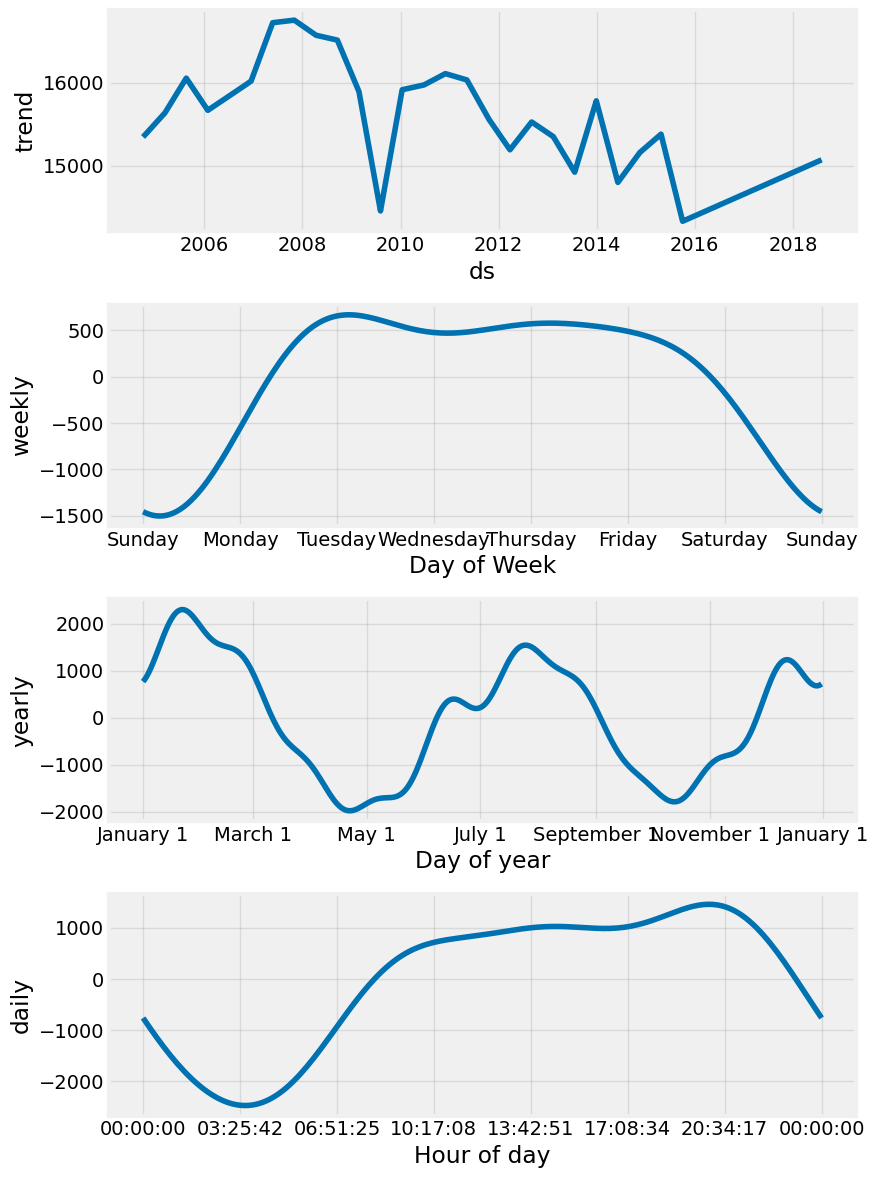

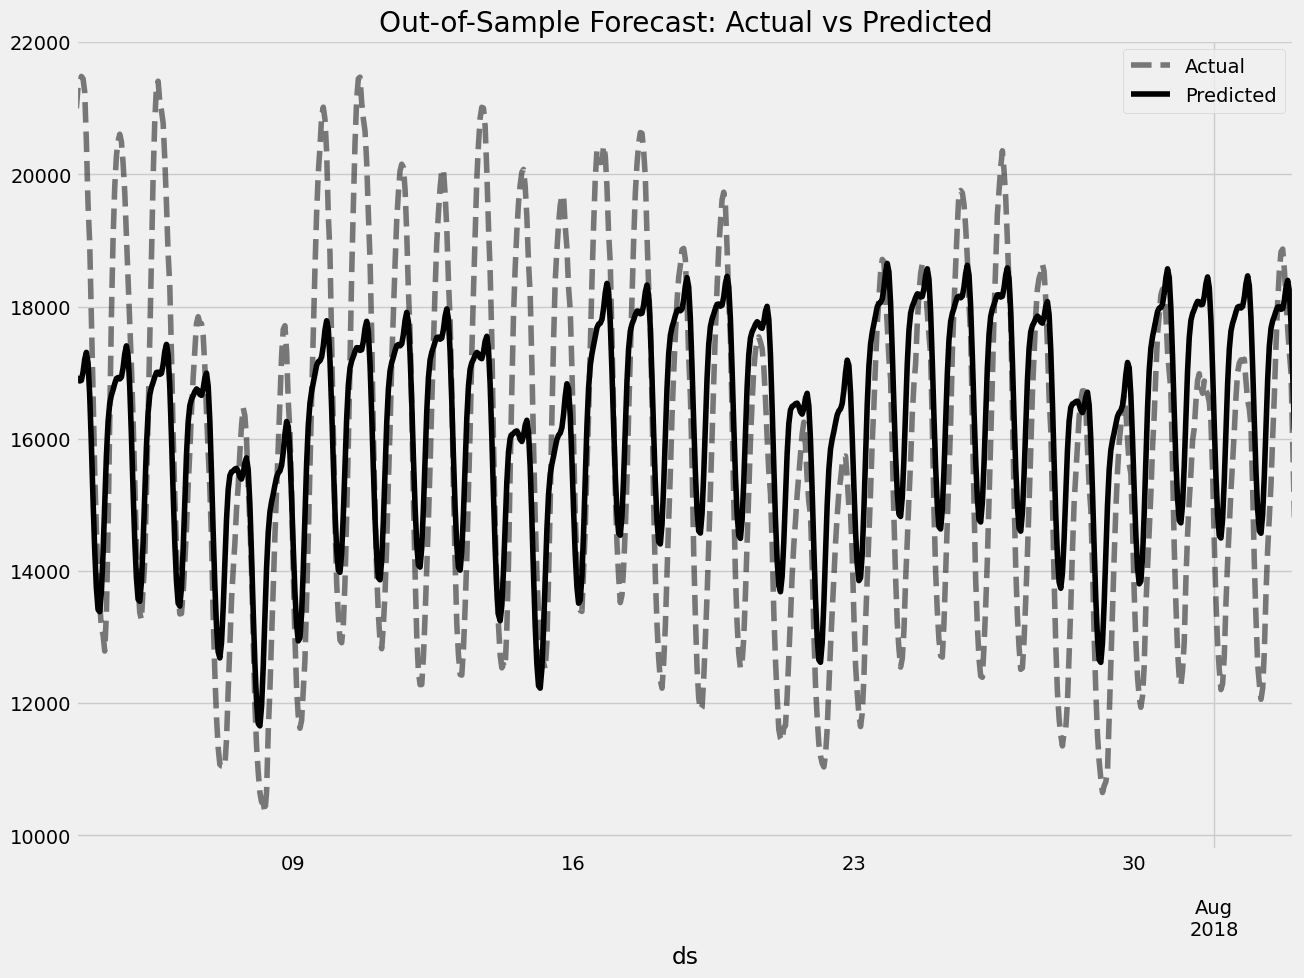

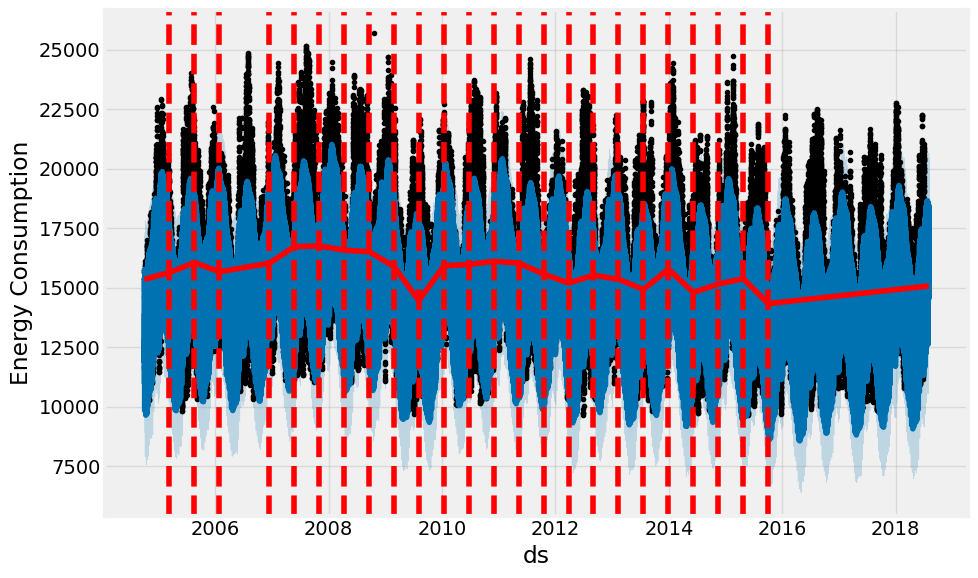

1.2556435790807383
1882.8478170588146


In [10]:
energy1 = df.copy()
energy1.reset_index(inplace=True)
energy1.columns = ['ds', 'y']

train_e = energy1.iloc[:-month]
test_e = energy1.iloc[-month:]

model = Prophet().fit(train_e)
n = len(test_e)
future = model.make_future_dataframe(n, freq='H')
forecast = model.predict(future)
model.plot_components(forecast)
plt.show()

prediction = forecast.iloc[test_e.index[0]:].set_index('ds')['yhat']

test_e.set_index('ds').plot(style='k--', alpha=0.5)
prediction.plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')
plt.show()

fig = model.plot(forecast, ylabel='Energy Consumption')
add_changepoints_to_plot(fig.gca(), model, forecast,
                         threshold=0.01)
plt.show()

print(rmspe(test_e['y'], prediction))
print(rmse(test_e['y'], prediction))


# Result:
By comparing the rmse scores with umc nad prophet, the ucm performed better


In [ ]:
# Neural Prophet
energy = df.copy()
energy.reset_index(inplace=True)
energy.columns = ['ds', 'y']

train_n = energy.iloc[:-month * 2]
val_n = energy.iloc[-month * 2:-month]
test_n = energy.iloc[-month:]

m = NeuralProphet()
metrics = m.fit(train_n, validation_df=val_n)

n = len(test_n) + len(val_n)
future = m.make_future_dataframe(df=train_n, periods=n)
forecast = m.predict(df=future)

fig6 = m.plot(forecast)
plt.show()

fig7 = m.plot_components(forecast)
plt.show()

fig8 = m.plot_parameters()
plt.show()

prediction1 = forecast.set_index('ds')['yhat1'].iloc[:-month]
prediction1 = forecast.set_index('ds').loc['2018-07-03 14:00:00':]['yhat1']

test_n.set_index('ds').plot(style='k--', alpha=0.5)
prediction1.plot(style='k')
plt.legend(['Actual', 'Predicted'])
plt.title('Out-of-Sample Forecast: Actual vs Predicted')

print(rmspe(test_n['y'].values, prediction.values))
print(rmse(test_n['y'].values, prediction.values))




Finding best initial lr:   0%|          | 0/276 [00:00<?, ?it/s]

In [ ]:
mod = NeuralProphet(learning_rate=0.1)

train_np, test_np = mod.split_df(df=energy, freq="H", valid_p=0.2)

train_results = mod.fit(df=train_np, freq="H")
test_results = mod.test(df=test_np)

print(test_results)

metrics = mod.fit(df=train_np, freq="H", validation_df=test_np, progress="plot")
plt.show()
print(metrics.tail(1))